# Demonstrate simple MESMER - CLIMADA coupling

## Import a demo exposures of buildings 

In [2]:
from climada.hazard import Hazard
from climada.util.api_client import Client

In [3]:
client = Client()

In [5]:
exp = client.get_litpop(country='DEU')

<GeoAxes: title={'center': "LitPop Exposure for ['DEU'] at 150 as, year: 2018, financial mode: pc,\nexp: (1, 1), admin1_calc: False"}>

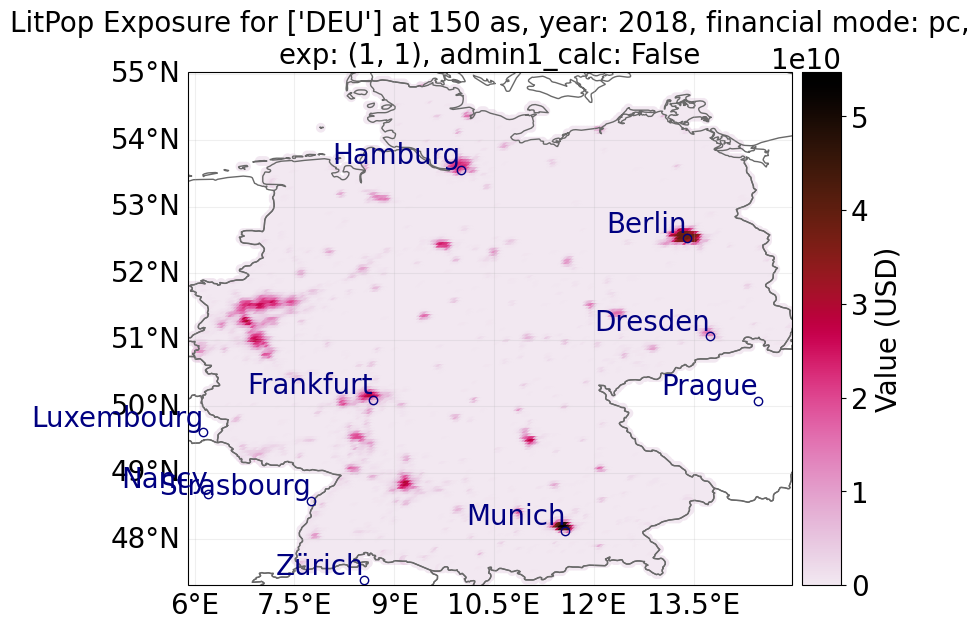

In [61]:
exp.plot_scatter()

## Define impact functions

In [6]:
from climada.entity import ImpactFunc, ImpactFuncSet

In [65]:
impfset = ImpactFuncSet([ImpactFunc.from_step_impf(haz_type='HP', intensity=(0, 1000, 2000), intensity_unit='mm/day')])

<Axes: title={'center': 'HP 1: '}, xlabel='Intensity (mm/day)', ylabel='Impact (%)'>

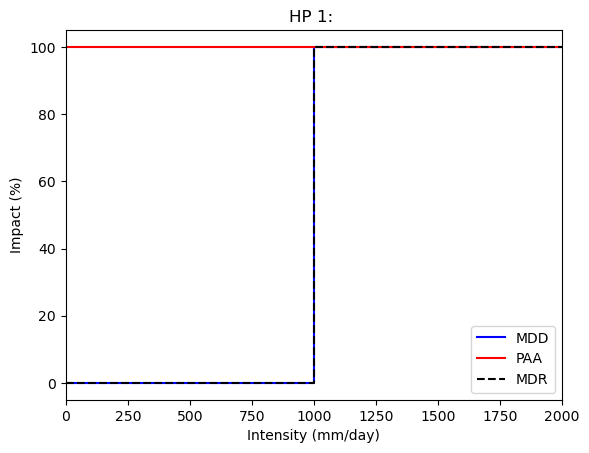

In [66]:
impfset.plot()

## Hazard

In [9]:
from pathlib import Path

In [10]:
DATA = Path('./Data/')

In [13]:
Hazard.from_xarray_raster??

Signature:
Hazard.from_xarray_raster(
    data: xarray.core.dataset.Dataset,
    hazard_type: str,
    intensity_unit: str,
    *,
    intensity: str = 'intensity',
    coordinate_vars: Optional[Dict[str, str]] = None,
    data_vars: Optional[Dict[str, str]] = None,
    crs: str = 'EPSG:4326',
    rechunk: bool = False,
)
Source:   
    @classmethod
    def from_xarray_raster(
        cls,
        data: xr.Dataset,
        hazard_type: str,
        intensity_unit: str,
        *,
        intensity: str = "intensity",
        coordinate_vars: Optional[Dict[str, str]] = None,
        data_vars: Optional[Dict[str, str]] = None,
        crs: str = u_const.DEF_CRS,
        rechunk: bool = False,
    ):
        """Read raster-like data from an xarray Dataset

        This method reads data that can be interpreted using three coordinates: event,
        latitude, and longitude. The names of the coordinates to be read from the
        dataset can be specified via the ``coordinate_vars`` parame

In [21]:
haz = Hazard.from_xarray_raster_file(
    DATA / 'rx1day_ERA5.nc',
    hazard_type='HP',
    intensity_unit='mm/day',
    intensity = 'tp',
    coordinate_vars = {'event': 'year', 'longitude':'lon', 'latitude':'lat'},
)

2024-09-25 10:46:11,699 - climada.hazard.io - WARNING - Failed to read values of 'year' as dates. Hazard.event_name will be empty strings


In [75]:
from shapely import Point
def shift_x(geometry, offset=-180):
    # For Point geometries
    if geometry.geom_type == 'Point':
        return Point(geometry.x + offset, geometry.y)
haz.centroids.gdf['geometry'] = haz.centroids.gdf['geometry'].apply(shift_x)

<GeoAxes: title={'center': 'Event ID 1:'}>

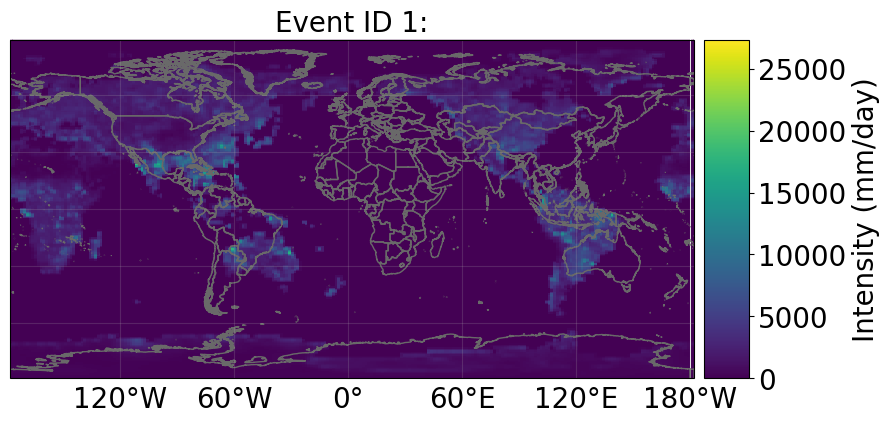

In [76]:
haz.plot_intensity(event=1)

In [70]:
haz.centroids.lon.min()
haz.centroids.lon.max()

359.0

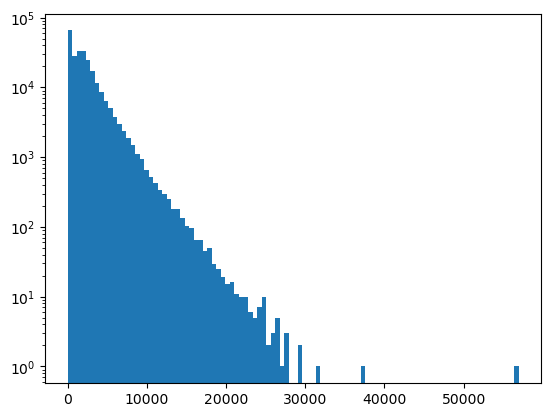

In [35]:
import matplotlib.pyplot as plt
plt.hist(haz.intensity.data, bins=100, log=True);

In [37]:
import xarray as xr
ds = xr.open_dataset(DATA / 'rx1day_ERA5.nc')

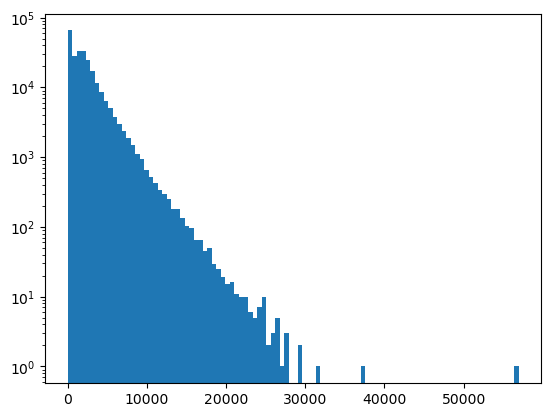

In [51]:
plt.hist(ds.tp.values.flatten(), log=True, bins=100);

## Impact Calc

In [1]:
from climada.engine import ImpactCalc

/Users/ckropf/opt/anaconda3/envs/climada_env/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [54]:
exp.gdf['impf_HP'] = 1

In [58]:
imp = ImpactCalc(exp, impfset, haz).impact()

2024-09-25 10:53:32,682 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 9876 coordinates.


<GeoAxes: title={'center': 'Expected annual impact'}>

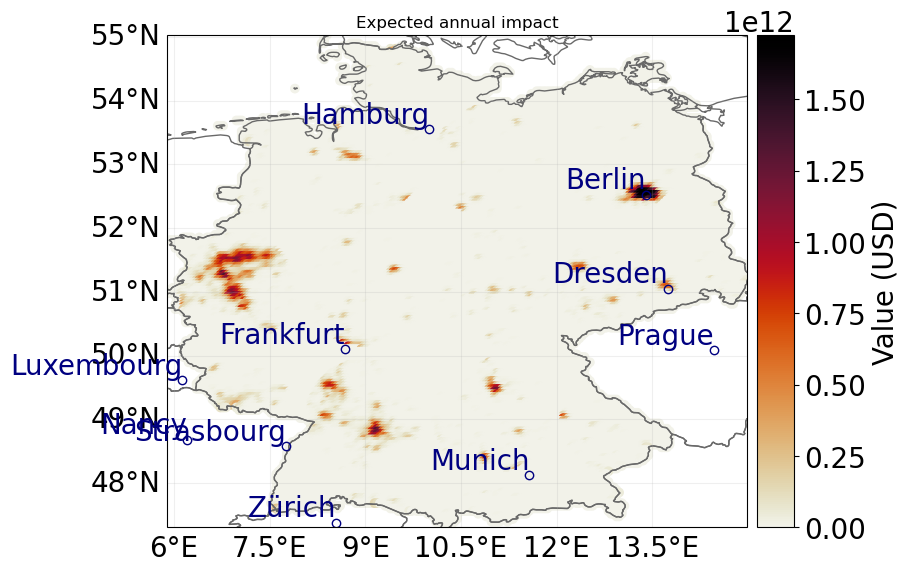

In [60]:
imp.plot_scatter_eai_exposure()